# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle

In [2]:
from absl import app
from absl import flags
from absl import logging

In [3]:
tf.__version__

'2.0.0-preview'

In [4]:
# not working 2.0: tf.logging -> logging
#logging.set_verbosity(logging.INFO)

In [7]:
logging.debug('test')
logging.info('test')

## Import the Data

In [8]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [9]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [10]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [11]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [12]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

In [13]:
x_test.nbytes/1024.0**2

7.476806640625

In [14]:
x_train.nbytes/1024.0**2

44.86083984375

In [15]:
y_test.nbytes/1024.0**2

0.0095367431640625

In [16]:
y_train.nbytes/1024.0**2

0.057220458984375

## Normalize and reorganize the data

In [17]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [19]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [20]:
x_train.shape

(60000, 784)

In [21]:
x_test.shape

(10000, 784)

## Reshape the labels

In [22]:
y_train.shape

(60000,)

In [23]:
y_test.shape

(10000,)

In [24]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [25]:
num_classes = len(np.unique(y_train))
num_classes

10

In [26]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [27]:
y_train.shape

(60000, 10)

In [28]:
y_test.shape

(10000, 10)

In [29]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

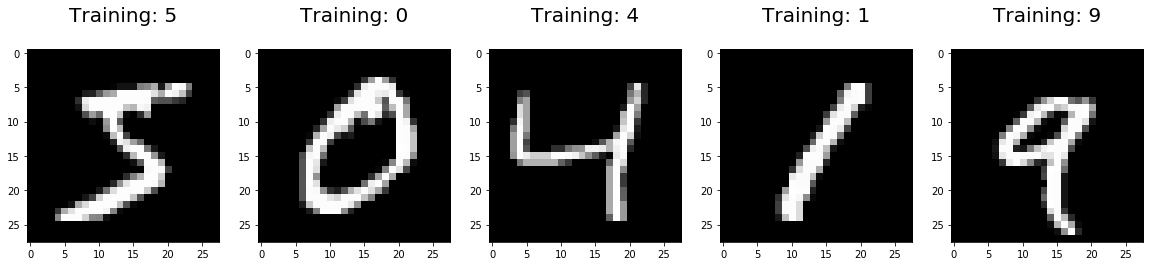

In [30]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [31]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 5

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

In [32]:
BATCH_SIZE, EPOCHS

(128, 5)

## Defined flags

In [33]:
# not working 2.0: tf.flags -> flags
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(flags.FLAGS)

In [34]:
flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
flags.DEFINE_string('model_dir', '../results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
flags.DEFINE_string('saved_dir', '../results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = flags.FLAGS
# new with 2.0
FLAGS(sys.argv)

['/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0/lib/python3.6/site-packages/ipykernel_launcher.py']

In [35]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --epoch: number of epoch
    (default: '5')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/pb/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag with that name.
    IMPORTANT: flags in this

## Using tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [36]:
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('test', 'predict', 'train')

In [43]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        logging.info("input_dataset_fn: PREDICT, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.EVAL:
        logging.info("input_dataset_fn: EVAL, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.TRAIN:
        logging.info("input_dataset_fn: TRAIN, {}".format(mode))
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # loop indefinitely
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        num_epochs = 1 # end-of-input after this
        
    print('the number of epoch: num_epoch =', num_epochs)
        
    # caching data
    #dataset = dataset.cache()
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    #dataset = dataset.map(map_func=parse_fn, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

In [44]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

the number of epoch: num_epoch = None
the number of epoch: num_epoch = 1


### Exploration dataset API

In [135]:
n=0
n_iter=10 #len(x_train)//BATCH_SIZE
for features, labels in training_dataset:
    try:
        start_time = time.clock()
        x,y = features, labels
        print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
        print(x.shape)
        print(y.shape)
        print('first label of the batch',np.argmax(y[0]),'\n')
        n+=1
        if n>=n_iter:
            print('number of iteration reached')
            break
    except tf.errors.OutOfRangeError:
        print('tf.errors.OutOfRangeError')
        break

iteration n: 0 execution time: 0.00012699999999199463 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 1 execution time: 1.2999999995599865e-05 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 2 execution time: 1.3999999993075107e-05 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 3 execution time: 1.1999999998124622e-05 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 4 execution time: 1.3999999993075107e-05 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 5 execution time: 7.999999999697138e-05 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 6 execution time: 9.999999974752427e-06 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 7 execution time: 1.100000000064938e-05 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 8 execution time: 1.100000000064938e-05 seconds
(128, 784)
(128, 10)
first label of the batch 

In [139]:
n=0
n_iter=1
for features, labels in testing_dataset:
    while True:
        try:
            start_time = time.clock()
            x,y = features, labels
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

0.001998000000014599 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

number of iteration reached


## Our model
### Build the model

In [168]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser (use tf.train and not tf.keras to use MirrorStrategy)
    # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
    #optimiser=tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9)
    # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
    # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
    # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
    # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)

   
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [169]:
# reset the model
tf.keras.backend.clear_session()

In [170]:
# build the model
model = baseline_model()

### Check the nuber of parameters

In [171]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [172]:
model.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [173]:
model.output_names

['dense_1']

## Keras Call back

### Print info during iterations

In [174]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

### TensorBoard

In [176]:
#keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
#tbCallBack=tf.keras.callbacks.TensorBoard(log_dir='../results/TensorBoard/Mnist/logs/', 
#                                          histogram_freq=1, 
#                                          write_graph=True)

## Store the original weights

In [177]:
initial_weights = model.get_weights()

## Fit the model using Keras and numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [179]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 3s - loss: 0.2172 - acc: 0.9370 - val_loss: 0.1217 - val_acc: 0.9618
Epoch 2/10
60000/60000 - 2s - loss: 0.1092 - acc: 0.9670 - val_loss: 0.1298 - val_acc: 0.9608
Epoch 3/10
60000/60000 - 2s - loss: 0.0918 - acc: 0.9732 - val_loss: 0.1289 - val_acc: 0.9668
Epoch 4/10
60000/60000 - 2s - loss: 0.0778 - acc: 0.9772 - val_loss: 0.1190 - val_acc: 0.9717
Epoch 5/10
60000/60000 - 2s - loss: 0.0732 - acc: 0.9797 - val_loss: 0.1422 - val_acc: 0.9691
Epoch 6/10
60000/60000 - 3s - loss: 0.0697 - acc: 0.9806 - val_loss: 0.1328 - val_acc: 0.9714
Epoch 7/10
60000/60000 - 2s - loss: 0.0625 - acc: 0.9831 - val_loss: 0.1598 - val_acc: 0.9714
Epoch 8/10
60000/60000 - 2s - loss: 0.0593 - acc: 0.9847 - val_loss: 0.1881 - val_acc: 0.9689
Epoch 9/10
60000/60000 - 2s - loss: 0.0534 - acc: 0.9861 - val_loss: 0.1509 - val_acc: 0.9742
Epoch 10/10
60000/60000 - 2s - loss: 0.0508 - acc: 0.9876 - val_loss: 0.2041 - val_acc: 0.9706


In [180]:
print(hist.history)

{'loss': [0.21717953401803972, 0.10917758003473282, 0.09176977903321386, 0.07778290131042401, 0.07319211648752293, 0.06971756339594722, 0.06250256696790457, 0.05933427373357117, 0.05336977696067964, 0.0507808894061173], 'acc': [0.93701667, 0.9670333, 0.97325, 0.97718334, 0.97966665, 0.9805667, 0.9830833, 0.98468333, 0.98611665, 0.9876], 'val_loss': [0.12166773548126221, 0.12982718848884106, 0.12888396408557892, 0.1189963302373886, 0.14218190791606902, 0.13277554471120237, 0.15981805674433708, 0.18809437324916944, 0.15093745285563637, 0.20406991792917228], 'val_acc': [0.9618, 0.9608, 0.9668, 0.9717, 0.9691, 0.9714, 0.9714, 0.9689, 0.9742, 0.9706]}


In [181]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20406991853305018
Test accuracy: 0.9706


In [182]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.05631555794287784
Train accuracy: 0.9859833


In [183]:
# with keras optimiser we save save the model+weight
model.save('../results/Models/Mnist/keras_model.h5')

## Fit the model using Keras annd tf.data.dataset

In [191]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(input_dataset_fn(x_train, y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=FLAGS.batch_size),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=input_dataset_fn(x_test, y_test, mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)),
               validation_steps=1, 
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
               epochs=EPOCHS,
               verbose = 2)

the number of epoch: num_epoch = None
the number of epoch: num_epoch = 1
Epoch 1/10
468/468 - 2s - loss: 0.3445 - acc: 0.9226 - val_loss: 0.1559 - val_acc: 0.9552
Epoch 2/10
468/468 - 2s - loss: 0.1222 - acc: 0.9639 - val_loss: 0.1227 - val_acc: 0.9655
Epoch 3/10
468/468 - 2s - loss: 0.0868 - acc: 0.9731 - val_loss: 0.1361 - val_acc: 0.9651
Epoch 4/10
468/468 - 2s - loss: 0.0731 - acc: 0.9771 - val_loss: 0.1484 - val_acc: 0.9649
Epoch 5/10
468/468 - 2s - loss: 0.0657 - acc: 0.9798 - val_loss: 0.1431 - val_acc: 0.9660
Epoch 6/10
468/468 - 2s - loss: 0.0582 - acc: 0.9816 - val_loss: 0.1509 - val_acc: 0.9646
Epoch 7/10
468/468 - 2s - loss: 0.0535 - acc: 0.9830 - val_loss: 0.1408 - val_acc: 0.9683
Epoch 8/10
468/468 - 2s - loss: 0.0536 - acc: 0.9838 - val_loss: 0.1608 - val_acc: 0.9659
Epoch 9/10
468/468 - 2s - loss: 0.0463 - acc: 0.9858 - val_loss: 0.1609 - val_acc: 0.9666
Epoch 10/10
468/468 - 2s - loss: 0.0424 - acc: 0.9868 - val_loss: 0.1566 - val_acc: 0.9688


In [192]:
print(hist.history)

{'loss': [0.34453886528857625, 0.12224854580445103, 0.0868404434991873, 0.07308664929686895, 0.06566301603357777, 0.05817660538312525, 0.05350063713794797, 0.05360552344635889, 0.04634311653714195, 0.04242700067984088], 'acc': [0.9226262, 0.9639423, 0.97314036, 0.9770967, 0.97975093, 0.9816206, 0.9830061, 0.9837573, 0.98579395, 0.98679554], 'val_loss': [0.1559320092201233, 0.12271258234977722, 0.13613088428974152, 0.14838959276676178, 0.1431269347667694, 0.1509007066488266, 0.14084689319133759, 0.16083888709545135, 0.1609259396791458, 0.15659475326538086], 'val_acc': [0.9552, 0.9655, 0.9651, 0.9649, 0.966, 0.9646, 0.9683, 0.9659, 0.9666, 0.9688]}


In [193]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1565948262046947
Test accuracy: 0.9688


In [194]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.041119411910375374
Train accuracy: 0.98751664


## Fit the model using tf.estimator and tf.data.dataset
### Create some helper function

In [195]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'SessionRunHook'

In [ ]:
time_hist = TimeHistory()

### Use tf.distribute.startegy work across multiple devices/machines

In [196]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
NUM_GPUS = 2
#strategy=None
## doesn't work with Keras ?!?
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

AttributeError: module 'tensorflow' has no attribute 'contrib'

### transfor keras model to estimator model
delete fist the folder for a clean start

In [134]:
! rm -r ../results/Models/Mnist/ckpt

In [ ]:
!rmdir /S /Q "../results/Models/Mnist/ckpt"

In [2]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

NameError: name 'model' is not defined

In [136]:
!ls ../results/Models/Mnist/ckpt

keras


In [ ]:
!dir /B "../results/Models/Mnist/ckpt"

### Training our model

In [57]:
def get_train_input_fn():
    return input_dataset_fn(x_train,
                            y_train, 
                            mode=tf.estimator.ModeKeys.TRAIN, 
                            batch_size=FLAGS.batch_size)

In [1]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=1000)
                            #hooks=[time_hist])

NameError: name 'estimator_train_model' is not defined

In [140]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

total time with the current strategy: 164.70961594581604 seconds


In [141]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

777.1252410794748 images/second


### Evaluating the accuracy of our model

In [142]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=len(y_train)),
                                    steps=1)

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-24-19:08:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-24-19:08:36
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98143333, global_step = 1000, loss = 0.06319532
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ../results/Models/Mnist/ckpt/model.ckpt-1000


In [143]:
score

{'accuracy': 0.98143333, 'loss': 0.06319532, 'global_step': 1000}

In [144]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 0.06319532
Train accuracy: 0.98143333
Train global steps: 1000


In [71]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-24-14:00:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-24-14:00:21
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.808, global_step = 10, loss = 0.77520794
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10: ../results/Models/Mnist/ckpt/model.ckpt-10


In [72]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.77520794
Test accuracy: 0.808
Test global steps: 10


### Generating predictions on our trained model

In [73]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test))))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [74]:
len(predictions)

10000

In [75]:
predictions[0].keys()

dict_keys(['dense_1'])

In [76]:
model.input_names

['dense_input']

In [77]:
model.output_names

['dense_1']

In [78]:
estimator_train_model.get_variable_names()

['dense/bias',
 'dense/bias/Adam',
 'dense/bias/Adam_1',
 'dense/kernel',
 'dense/kernel/Adam',
 'dense/kernel/Adam_1',
 'dense_1/bias',
 'dense_1/bias/Adam',
 'dense_1/bias/Adam_1',
 'dense_1/kernel',
 'dense_1/kernel/Adam',
 'dense_1/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [79]:
len(predictions)

10000

In [80]:
for i in range(10):
    prediction_array = predictions[i]['dense_1']
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', np.argmax(y_test[i]))
    print("Predicted label: ", predicted_label)

Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 5
Predicted label:  4
Actual label: 9
Predicted label:  9


## Model serving

In [81]:
estimator_train_model.params

{}

In [82]:
estimator_train_model.get_variable_names()

['dense/bias',
 'dense/bias/Adam',
 'dense/bias/Adam_1',
 'dense/kernel',
 'dense/kernel/Adam',
 'dense/kernel/Adam_1',
 'dense_1/bias',
 'dense_1/bias/Adam',
 'dense_1/bias/Adam_1',
 'dense_1/kernel',
 'dense_1/kernel/Adam',
 'dense_1/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [85]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [98]:
estimator_train_model.export_saved_model(FLAGS.saved_dir, 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../results/Models/Mnist/pb/temp-b'1548343514'/saved_model.pb


b'../results/Models/Mnist/pb/1548343514'

In [146]:
!ls ../results/Models/Mnist/pb/1548343514/saved_model.pb 

../results/Models/Mnist/pb/1548343514/saved_model.pb


In [150]:
! saved_model_cli show --dir ../results/Models/Mnist/pb/1548343514/ --tag serve --signature_def predict

The given SavedModel SignatureDef contains the following input(s):
The given SavedModel SignatureDef contains the following output(s):
Method name is: 


In [45]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
AttributeError: module 'tensorflow' has no attribute 'GIT_VERSION'


In [46]:
!conda list

# packages in environment at /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0:
#
# Name                    Version                   Build  Channel
absl-py                   0.7.0                     <pip>
appnope                   0.1.0            py36hf537a9a_0  
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                     <pip>
astroid                   2.1.0                    py36_0  
atomicwrites              1.2.1                    py36_0  
attrs                     18.2.0           py36h28b3542_0  
autopep8                  1.4.3                    py36_0  
backcall                  0.1.0                    py36_0  
blas                      1.0                         mkl  
bleach                    3.1.0                    py36_0  
ca-certificates           2018.12.5                     0  
certifi                   2018.11.29               py36_0  
cffi                      1.11.5           py36h6174b99_1  
chardet             